https://seaborn.pydata.org/generated/seaborn.clustermap.html


In [2]:
# imports required by this notebook

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
import joblib

In [3]:
# files used in the model creation process
orig_file = '../datasets/WA_Fn-UseC_-HR-Employee-Attrition.csv'
processed_file = '../datasets/HR_attrition_orig_proc.csv'

train_x_file = '../datasets//HR_attrition_train_x.csv'
test_x_file = '../datasets/HR_attrition_test_x.csv'
train_y_file = '../datasets/HR_attrition_train_y.csv'
test_y_file = '../datasets/HR_attrition_test_y.csv'

train_x_nb_file = '../datasets/HR_attrition_train_x_nb.csv'
test_x_nb_file = '../datasets/HR_attrition_test_x_nb.csv'

train_x_lr_file = '../datasets/HR_attrition_train_x_lr.csv'
test_x_lr_file = '../datasets/HR_attrition_test_x_lr.csv'
train_x_nn_file = '../datasets/HR_attrition_train_x_nn.csv'
test_x_nn_file = '../datasets/HR_attrition_test_x_nn.csv'


In [4]:

# Constants

ISRESIGNED_T = 'Attrition'

# employee related information
AGE = 'Age'
EDUCATION_T = 'EducationField'
GENDER_T = 'Gender'
COMPANIES = 'NumCompaniesWorked'
STATUS_T = 'MaritalStatus'
HOMEDISTANCE = 'DistanceFromHome'

# role of the employee in the company
ROLE_T = 'JobRole'
LEVEL = 'JobLevel'
DEPARTMENT_T = 'Department'
YEARSCOMPANY = 'YearsAtCompany'
YEARSEMPLOYED = 'TotalWorkingYears'
YEARSROLE = 'YearsInCurrentRole'
YEARSLASTPROMO = 'YearsSinceLastPromotion'
YEARSMANAGER = 'YearsWithCurrManager'

# satisfaction informaiton
SATISFACTION = 'JobSatisfaction'
TEAMCLICK = 'RelationshipSatisfaction'
LIFEBALANCE = 'WorkLifeBalance'
ENVIRONMENT = 'EnvironmentSatisfaction'

# salary and money related
SALARY = 'MonthlyIncome'
MONTHLYRATE = 'MonthlyRate'
DAILYRATE = 'DailyRate'  # Daily rate = the amount of money you are paid per day
HOURLYRATE = 'HourlyRate'

# Percent salary hike = the % change in salary from 2016 vs 2015.
LASTINCREMENTPERCENT = 'PercentSalaryHike'
STOCKOPTIONS = 'StockOptionLevel' # Stock option level = how much company stocks you own.
TRAINING = 'TrainingTimesLastYear'

# rating and involvement related
RATING = 'PerformanceRating'
INVOLVEMENT = 'JobInvolvement'
OVERTIME_T = 'OverTime'  # Y/N
TRAVEL_T = 'BusinessTravel'  # rare / requent

# redundant fields
EMPLYEENO_R = 'EmployeeNumber'  # number
EMPLOYEECOUNT_R = 'EmployeeCount'  # all 1
ISOVER18_R = 'Over18'  # all Y
STDHOURS_R = 'StandardHours'  # all 40


In [5]:
column_drop_list = [EMPLYEENO_R, EMPLOYEECOUNT_R,
                    ISOVER18_R, STDHOURS_R]
encode_list = [GENDER_T, STATUS_T, DEPARTMENT_T, ROLE_T,
               OVERTIME_T, TRAVEL_T, ISRESIGNED_T, EDUCATION_T]

In [6]:
# def load_data(filename, encode_list, column_drop_list)

data_df = pd.read_table(orig_file, sep=',')
# print(data_df)
contains_nulls = False
# check that dataframe does not contain null values
if data_df.isnull().values.any():
    contains_nulls = True

header_orig = np.array(data_df.columns.values).squeeze()
data_orig = np.array(data_df.values)

# create a clone dataframe that will be 'massaged'
data_df_copy = data_df.copy(deep=True)

for encode_item in encode_list:
    data_df_copy[encode_item].replace(data_df_copy[encode_item].unique(), range(
        0, len(data_df_copy[encode_item].unique())), inplace=True)

for drop_column_item in column_drop_list:
    del data_df_copy[drop_column_item]

header_massaged = np.array(data_df_copy.columns.values).squeeze()
data_massaged = np.array(data_df_copy.values)
# print(data_massaged)
data_analytics = {
    'nulls' : contains_nulls,
    'shape': data_df.shape,
    'description': data_df_copy.describe(),
    'correlation': data_df_copy.corr()
}
data_m_df = pd.DataFrame(data=data_massaged,
                            columns=header_massaged)

# header_orig: 
# data_orig: 
# header_massaged: 
# data_massaged: 
# data_analytics: 
# data_m_df: 


In [7]:
if (data_analytics['nulls'] == True):
    print('Dataset contains null values')
else:
    print('Dataset does not contain null values')

print('Dataset shape: {}'.format(data_analytics['shape']))

print(data_analytics['description'])



Dataset does not contain null values
Dataset shape: (1470, 35)
               Age    Attrition  BusinessTravel    DailyRate   Department  \
count  1470.000000  1470.000000     1470.000000  1470.000000  1470.000000   
mean     36.923810     0.838776        0.392517   802.485714     0.739456   
std       9.135373     0.367863        0.665455   403.509100     0.527792   
min      18.000000     0.000000        0.000000   102.000000     0.000000   
25%      30.000000     1.000000        0.000000   465.000000     0.000000   
50%      36.000000     1.000000        0.000000   802.000000     1.000000   
75%      43.000000     1.000000        1.000000  1157.000000     1.000000   
max      60.000000     1.000000        2.000000  1499.000000     2.000000   

       DistanceFromHome    Education  EducationField  EnvironmentSatisfaction  \
count       1470.000000  1470.000000     1470.000000              1470.000000   
mean           9.192517     2.912925        1.462585                 2.721769   


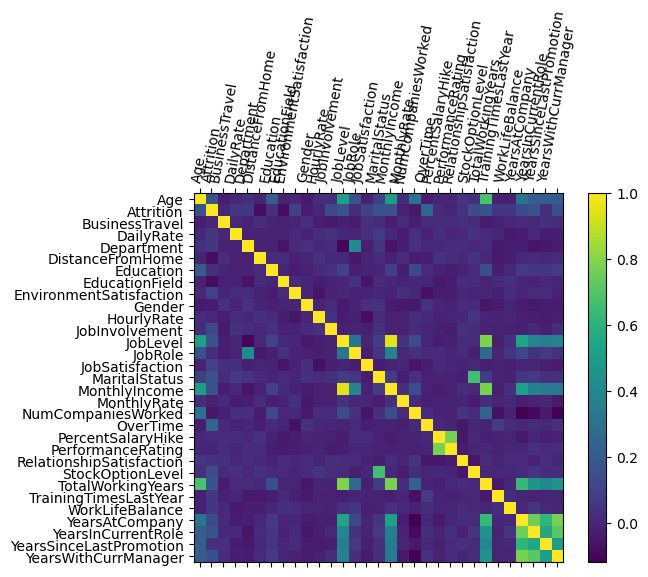

In [8]:
# Plots the correlation matrix
    

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data_analytics['correlation'])
fig.colorbar(cax)
ticks = np.arange(0, len(header_massaged), 1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(header_massaged)
ax.set_yticklabels(header_massaged)

for tick in ax.get_xticklabels():
    tick.set_rotation(80)

plt.show()


In [9]:
att = data_m_df.pop('Attrition')


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


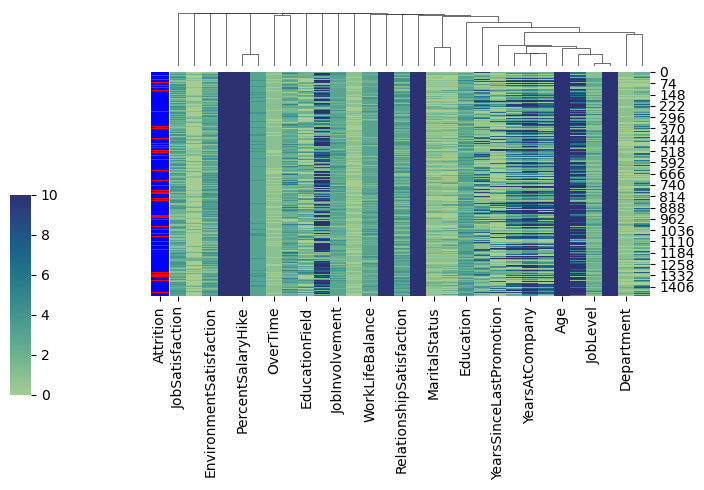

In [11]:
lut = dict(zip(att.unique(), "rbg"))
row_colors = att.map(lut)
sns.clustermap(data_m_df, figsize=(7, 5),
               row_cluster=False,
            #    standard_scale=1,
            #    z_score=0, center=0,
            #    dendrogram_ratio=(.1, .2),
               row_colors=row_colors,
               cmap="crest", 
               vmin=0, 
               vmax=10,
               metric="correlation", method="single",
               cbar_pos=(0, .2, .03, .4))


In [13]:
features_to_analyse = [
    EDUCATION_T, GENDER_T,
    COMPANIES, STATUS_T,
    ROLE_T, LEVEL,
    DEPARTMENT_T,
    SATISFACTION, TEAMCLICK,
    LIFEBALANCE, ENVIRONMENT,
    STOCKOPTIONS, TRAINING,
    RATING,
    INVOLVEMENT, OVERTIME_T, TRAVEL_T
]

In [15]:
def analysis_attrition_feature(header, data, feature_id, attrition_feature_id,
                               attrition_true=1, attrition_false=0):
    """
    Analyses the attrition of a specified feature. For example if the feature
    is the departments this function will give the number of employees,
    number of terminations and attrition per department

    Arguments:
    header -- the header information of this dataset
    data -- the dato to process
    feature_id -- the column name of the feature to examine (e.g. Departments)
    left_feature_id -- the column name of the attrition column
    left_true -- the value of the left column when the employee has left
    left_false -- the value of the left column when the employee is still employed

    Returns:
    results -- hashmap of results having:
                Categories, array of categories of theis feature
                Current, array of current employees for each feature
                Left, array of left employees for each feature
                Attrition, array for the attrition for each feature
    """
    results = {}

    # the index in the data that points to the attrition
    left_idx = np.argwhere(header == attrition_feature_id).squeeze()

    # the index in the data that points to the department of the employee
    feature_idx = np.argwhere(header == feature_id).squeeze()

    # the names of the categories in this feature
    # e.g. all teh department names under the header departments
    categories = np.unique(data[:, np.argwhere(header == feature_id)])

    category_employees_current = np.empty((len(categories), 0), dtype=int)
    category_employees_left = np.empty((len(categories), 0), dtype=int)

    for category in categories:
        # filter the data for the feature
        feature_data = data[np.where(
            data[:, feature_idx] == category), :].squeeze()

        # extract emplyees still employed and add their count to the current employees array
        still_working = len(
            np.where(feature_data[:, left_idx] == attrition_false)[0])

        category_employees_current = np.append(
            category_employees_current, [still_working])

        # extract emplyees that left and add their count to the left employees array
        left = len(np.where(feature_data[:, left_idx] == attrition_true)[0])
        category_employees_left = np.append(category_employees_left, [left])
        #print('{} -{}'.format(feature, feature_employees_left.shape))

    feature_percentage_attrition = category_employees_left / (category_employees_current
                                                              + category_employees_left) * 100

    # move all results in hashmap
    results['categories'] = categories
    results['current'] = category_employees_current
    results['left'] = category_employees_left
    results['attrition'] = feature_percentage_attrition

    return results


In [17]:
def plot_attrition_curve(results, title, fig, position):
    """
    Plots the the number of employees employed vs the number of employees left
    of all the various categories for a given feature.
    For example if we cansider the departments feature, this function will plot a 
    bar graph of the current and resigned employees for eveery department.
    It will also superimpose the attrition values for each category

    Arguments:
    results -- dictionary containing all the data necessary
                'Features'
    """
    plt.gcf().subplots_adjust(bottom=0.4)

    categories = results['categories']
    employees_current = results['current']
    employees_left = results['left']
    percentage_attrition = results['attrition']

    X = range(0, len(categories), 1)

    ax1 = fig.add_subplot(position)
    fig.suptitle(title)

    ax1.bar(X, employees_current, color='b', alpha=0.5)
    ax1.bar(X, employees_left, color='r', alpha=0.5, bottom=employees_current)
    ax1.set_ylabel('Employees current & left')

    ax2 = ax1.twinx()
    ax2.plot(X, percentage_attrition, color='b')
    ax2.set_ylim([0, np.max(percentage_attrition)+1])
    ax2.set_ylabel('% Attrition')

    ax2.set_xticks(X)
    ax2.set_xticklabels(categories)

    for tick in ax1.get_xticklabels():
        tick.set_rotation(80)


C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_10228\331522519.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.where(feature_data[:, left_idx] == attrition_false)[0])
C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_10228\331522519.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  left = len(np.where(feature_data[:, left_idx] == attrition_true)[0])
C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_10228\331522519.py:55: RuntimeWarning: invalid value encountered in true_divide
  feature_percentage_attrition = category_employees_left / (category_employees_current


ValueError: Axis limits cannot be NaN or Inf

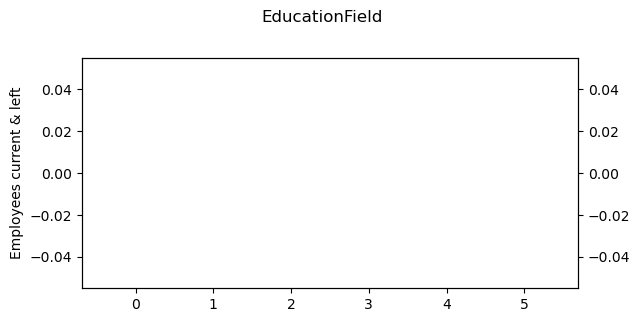

In [18]:
for feature in features_to_analyse:
    fig = plt.figure()
    results = analysis_attrition_feature(
        header_massaged, data_massaged, feature, ISRESIGNED_T, 'Yes', 'No')
    plot_attrition_curve(results, feature, fig, 111)
    plt.show()


In order to execute this analysis step, a list of the features to be analysed is necessary. The list is used to generate the relevant plots.

# Observations

The following list highlights the main thoughts that emerged from this analysis:
1.	Employees that studied in HR, Marketing and Technical had a higher attrition rate than all the others.
2.	Sales representatives had a tremendously high attrition rate, whilst managers, directors and people in the more senior roles tended to remain in the company’s workforce.
3.	Attrition was slightly higher for males.
4.	A ‘sweet spot’ for employees that were in their third fourth or fifth job was noticed. The attrition rate in these cases was remarkably low.
5.	Singles were more likely to leave the company than divorced and married employees.
6.	Attrition was slightly less in the R&D department when compared to the sales and HR departments.
7.	Employees that were not satisfied in the company, that were very unhappy in their team, that did not have a healthy work life balance, and that were not happy with their work environment were more likely to leave. In all cases we noticed that the attrition rate for ‘very unhappy’ employees was around double than for the other cases.
8.	There was a preferred stock option scheme, the option number 3. The attrition rate for this scheme was much lower than for the other three.
9.	Training was also a very important factor. We noticed that the attrition rate for the employees that received no training was around 25%, compared to values that range from 10% to 15% for employees that did receive some training.
10.	The performance rating had no effect on attrition. As we noticed before, all employees were graded as either 3 or 4. In this analysis we noticed that turnover was practically the same in both cases. In addition, we noticed that a only a small percentage (12%) of the total workforce were rated a grade 4.
11.	Employees that were not involved in their work tended to leave.
12.	Overtime had a negative effect on attrition. We noticed that employees were more likely to leave when they did overtime. 
13.	A similar situation was encountered when travel was considered. Employees that travelled frequently were more likely to leave.

# Further Analysis

In the above exercise the categorical data in the set was analysed with regards to attrition level. 
In the following, the same attempt was being carried out on the real-valued data in the set. As in the first case, two functions were developed; the first function selects and formats the data, whilst the second plots it in a scatter plot.

In [ ]:
def analysis_comparison_features(header, data, x_feature_id, y_feature_id, z_feature_id, filter_feature_id=None, filter_feature_value=None):
    """
    """
    # the index of the number of years at the company
    x_feature_idx = np.argwhere(header == x_feature_id).squeeze()

    # the index of the salary at the company
    y_feature_idx = np.argwhere(header == y_feature_id).squeeze()

    # the index of the salary at the company
    z_feature_idx = np.argwhere(header == z_feature_id).squeeze()

    if filter_feature_id != None:
        filter_feature_idx = np.argwhere(header == filter_feature_id)
        filtered_data = data[np.where(
            data[:, filter_feature_idx] == filter_feature_value), :]
    else:
        filtered_data = data

    x_data = filtered_data[:, x_feature_idx]
    y_data = filtered_data[:, y_feature_idx]
    z_data = filtered_data[:, z_feature_idx]

    return x_data, y_data, z_data


In [ ]:
def plot_comparison_curve(x_title, y_title, x_data, y_data, z_data):

    left_color = 'lightcoral'
    remained_color = 'green'

    z_left = np.where(z_data == 0)
    z_remained = np.where(z_data == 1)

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    colors = [left_color, remained_color]

    axScatter.set_xlabel(x_title)
    axScatter.set_ylabel(y_title)

    axScatter.scatter(x_data, y_data, c=z_data, cmap=ListedColormap(colors), alpha=0.5)

    x_bins = min(30, len(np.unique(x_data)))

    axHistx.hist(x_data[z_left], bins=x_bins, color=left_color, alpha=0.5)
    axHistx.hist(x_data[z_remained], bins=x_bins, color=remained_color, alpha=0.5)

    x_left_hist = np.histogram(x_data[z_left], bins=x_bins)[0]
    x_remained_hist = np.histogram(x_data[z_remained], bins=x_bins)[0]
    # added a small factor to avoid division errors
    attrition = x_left_hist / (x_remained_hist + x_left_hist + 0.00005) * 100

    axHistx_2 = axHistx.twinx()
    axHistx_2.plot(np.histogram(x_data[z_left], bins=x_bins-1)[1], attrition, color='b')
    axHistx_2.set_ylim([0, 105])
    axHistx_2.set_ylabel('% Attrition')

    y_bins = min(30, len(np.unique(y_data)))

    axHisty.hist(y_data[z_left], bins=y_bins, color=left_color,
                 alpha=0.5, orientation='horizontal')
    axHisty.hist(y_data[z_remained], bins=y_bins, color=remained_color,
                 alpha=0.5, orientation='horizontal')

    plt.show()


In [ ]:
def analyse_comparison(header, data, comparison_sets):
    for feature_1, feature_2 in comparison_sets:
        x, y, z = analysis_comparison_features(
            header, data, feature_1, feature_2, constants.ISRESIGNED_T)
        plot_comparison_curve(feature_1, feature_2, x, y, z)


The execution of this analysis step is very similar to the execution of the first step. A list that contained the featured to be analysed was created and then it was used to create the plots.

In [ ]:
comparison_sets = [(constants.SALARY, constants.AGE),
                    (constants.SALARY, constants.YEARSEMPLOYED),
                    (constants.LASTINCREMENTPERCENT, constants.RATING)]

analyse_comparison(m_header, m_data, comparison_sets)

# Observations

Three plots were generated from this analysis step. It was noticed that salary was a major trigger to leave the company, especially for young employees; as the attrition rate was nearly 50 % for employees who were less than thirty years old and that has their salary in the lowest band.
It was also noticed that there was some relation between the salary and number of years in the company, and somewhat, either by natural progression in the company’s ranks or by turnover there were no employees with a seniority of over 20 years in the lowest salary bands.
Finally, an increment structure was deduced when the salary increments were examined with the employees’ grade. There was a clear discrimination between 3 and 4 performers, where the 4 performers received an increment that had a maximum value of 25% (there were 18 such instances), whilst and the lowest increment for a 3 performer was 11% (210 cases).

# Part 2 - Machine Learning Models

Numerous other studies that could have been carried out on this data. But having gained some insight on the characteristics of this company, an attempt to build some models was then carried out.
The results of several classification models, namely:
1.	Naïve Bayes
2.	Logistic Regression
3.	K-Nearest Neighbours
4.	Neural Network
were then compared.

The procedure adopted to engineer the data so that these models could be executed is illustrated in the diagram below:

![](https://storage.googleapis.com/kagglesdsdata/datasets/16151/21316/HR%20ML.jpg?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1521191545&Signature=PwjVhdwuNsnLV53eGWLG9aIlvD5kTkcoSlPhzOQmh5tmpsqgeC7WSq5IkpBsLn5P3qzrN4h6dqBkIb99fk%2FsIJCtbZmlUOletjGvBNWYAJ%2FESOv%2FPIjOjJ5HtxdmFluzZLI%2BD2PZtMyyJbysTgXGbPmYyFffacN%2F19t5%2FUavG4iP4EanjB6iA9TG0tnV3nk708NZ5n4nf7oHEey5BJ6c9Gv21cvjmpmKNTVMSdekuKDlLvIJyde%2Fw81E2Op9WGcNke%2BOX%2F%2FxmoktT1eUdXx54HiXyMtrevncIcezhHBi8%2BiSM1PPhOBkFDbNbKz4XFScbYzINJHvee5uItVHNHx4ow%3D%3D)


As a first step, the data is ‘cleaned’ from redundant information and the categorical text fields are coded in a numerical equivalent as explained earlier on in this notebook. The result of this step is saved in a file.
The data is the split in train and test sets, where an 80/20 split was applied. The output feature, or the ‘Attrition’ field was also extracted and saved in another file, so that an X and Y files were created for both training and testing sets.

This data was then further processed to create the data required for each specific model. For example, in the Naïve Bayes case, the continuous fields were discretized using a number of buckets. Similarly, in the Neural Networks case, the continuous data was standardized and the categorical data was encoded using dummy coding.

In all cases the resulting data-sets were stored in files.


# Helper Scripts

Several  functions were used to create the model data set files. They were not executed in this notebook as Kaggle had some limitations when new data files were created. However, they are included below for completeness sake.

In [ ]:
def save_data(filename, header, data, override=False):
    """
    saves a dataset to file

    Arguments:
    filename -- the name of the dataset file
    header -- the data header
    data -- the data information

    Returns:
    """

    script_dir = os.path.dirname(__file__)
    abs_data_file_path = os.path.join(script_dir, filename)

    if (os.path.exists(abs_data_file_path) is False) or (override is True):
        # create dataframe with right format
        data_frame = pd.DataFrame(data=data, columns=header)
        # save data, remove index coluum
        data_frame.to_csv(abs_data_file_path, index=False)

In [ ]:
def partition_data(data_orig, train_percentage=0.6, test_percentage=0.2):
    """
    Divides a dataset in three parts after randomly rearranging its rows. Default partitions
    are as follows:
    Training set -- 60% of data
    Testing set -- 20% of data
    Dev Set -- 20% of data

    Arguments:
    data_orig -- the original, complete dataset
    train_percentage -- the percentage of the dataset that will become training data
    test_percenntage -- the percentage of the dataset that will become testing data
                        hence the development dataset will become the remainder
    Returns:
    train_set -- the training data set
    test_set -- the testing data set
    dev_set -- the development data set
    """
    # shuffle data. as data is shuffled accross rows, it requires the double transpose
    np.random.shuffle(data_orig)
    data_orig = data_orig

    train_set_size = (int)(data_orig.shape[0] * train_percentage)
    test_set_size = (int)(data_orig.shape[0] * test_percentage)

    train_set = data_orig[:train_set_size, :]
    test_set = data_orig[train_set_size:train_set_size+test_set_size, :]
    dev_set = data_orig[train_set_size+test_set_size:, :]

    return train_set, test_set, dev_set


In [ ]:
def prepare_model_data(rewrite_files=False):
    '''
    Prepares the data set files used by the models.

    Returns:
    results -- dictionary containing the following
        train_x_nb -- training x for naive bayes data set
        train_y -- training y data set
        test_x_nb -- test x for naive bayes data set
        test_y -- test y data set
        train_x_nn -- training x for neural nets (& Logistic regression)  data set
        test_x_nn -- test x for neural nets (& Logistic regression)  data set
    '''

    # step 1:
    column_drop_list = [constants.EMPLYEENO_R, constants.EMPLOYEECOUNT_R,
                        constants.ISOVER18_R, constants.STDHOURS_R]
    encode_list = [constants.GENDER_T, constants.STATUS_T, constants.DEPARTMENT_T, constants.ROLE_T,
                   constants.OVERTIME_T, constants.TRAVEL_T, constants.ISRESIGNED_T, constants.EDUCATION_T]

    _, _, m_header, m_data, _ = load_data(
        constants.orig_file, encode_list, column_drop_list)

    save_data(constants.processed_file, m_header, m_data, override=rewrite_files)

    # step 2:
    train_data, test_data, _ = partition_data(m_data, 0.8, 0.2)

    output_idx = np.argwhere(m_header == constants.ISRESIGNED_T).squeeze()

    train_y = train_data[:, output_idx]
    train_x = np.delete(train_data, output_idx, 1)

    test_y = test_data[:, output_idx]
    test_x = np.delete(test_data, output_idx, 1)

    traintest_header = np.delete(m_header, output_idx, 0)

    save_data(constants.train_x_file, traintest_header, train_x, override=rewrite_files)
    save_data(constants.train_y_file, np.array([constants.ISRESIGNED_T]), train_y, override=rewrite_files)
    save_data(constants.test_x_file, traintest_header, test_x, override=rewrite_files)
    save_data(constants.test_y_file, np.array([constants.ISRESIGNED_T]), test_y, override=rewrite_files)

    # to execute naive bayes we will discretise continuous data
    column_bins_definition = {constants.AGE: 10, constants.DAILYRATE: 10,
                              constants.HOMEDISTANCE: 10, constants.SALARY: 10,
                              constants.HOURLYRATE: 10, constants.MONTHLYRATE: 10,
                              constants.YEARSEMPLOYED: 5, constants.YEARSCOMPANY: 5,
                              constants.YEARSROLE: 5, constants.YEARSLASTPROMO: 5,
                              constants.YEARSMANAGER: 5, constants.LASTINCREMENTPERCENT: 16}

    train_x_nb = digitize_columns(
        traintest_header, train_x, column_bins_definition)
    test_x_nb = digitize_columns(
        traintest_header, test_x, column_bins_definition)

    save_data(constants.train_x_nb_file, traintest_header, train_x_nb, override=rewrite_files)
    save_data(constants.test_x_nb_file, traintest_header, test_x_nb, override=rewrite_files)

    columns_norm = [constants.AGE, constants.DAILYRATE,
                    constants.HOMEDISTANCE, constants.SALARY,
                    constants.HOURLYRATE, constants.MONTHLYRATE,
                    constants.YEARSEMPLOYED, constants.YEARSCOMPANY,
                    constants.YEARSROLE, constants.YEARSLASTPROMO,
                    constants.YEARSMANAGER, constants.LASTINCREMENTPERCENT]

    train_x_lr = feature_scale_columns(traintest_header, train_x, columns_norm)
    test_x_lr = feature_scale_columns(traintest_header, test_x, columns_norm)

    save_data(constants.train_x_lr_file, traintest_header, train_x_lr, override=rewrite_files)
    save_data(constants.test_x_lr_file, traintest_header, test_x_lr, override=rewrite_files)

    encode_list_nn = [constants.GENDER_T, constants.STATUS_T, constants.DEPARTMENT_T, constants.ROLE_T,
                      constants.OVERTIME_T, constants.TRAVEL_T, constants.EDUCATION_T,
                      constants.ENVIRONMENT, constants.INVOLVEMENT, constants.LEVEL,
                      constants.SATISFACTION, constants.COMPANIES, constants.RATING, constants.TEAMCLICK,
                      constants.STOCKOPTIONS, constants.TRAINING, constants.LIFEBALANCE]

    train_test_header_nn, train_x_nn = encode_columns_nn(
        traintest_header, train_x_lr, encode_list_nn)
    _, test_x_nn = encode_columns_nn(
        traintest_header, test_x_lr, encode_list_nn)

    save_data(constants.train_x_nn_file, train_test_header_nn, train_x_nn, override=rewrite_files)
    save_data(constants.test_x_nn_file, train_test_header_nn, test_x_nn, override=rewrite_files)

    results = {}

    results['train_x_nb'] = train_x_nb
    results['train_y'] = train_y
    results['test_x_nb'] = test_x_nb
    results['test_y'] = test_y
    results['train_x_nn'] = train_x_nn
    results['test_x_nn'] = test_x_nn
    return results

In the next function, data-sets that were required by the machine learning models were loaded from the files and returned in a dictionary.


In [ ]:
def load_model_data():
    '''
    Loads the model datasets from the respective files

    Returns:
    results -- dictionary containing the following
        train_x_nb -- training x for naive bayes data set
        train_y -- training y data set
        test_x_nb -- test x for naive bayes data set
        test_y -- test y data set
        train_x_nn -- training x for neural nets (& Logistic regression)  data set
        test_x_nn -- test x for neural nets (& Logistic regression)  data set
    '''
    _, train_x_nb, _, _, _ = load_data(constants.train_x_nb_file,[],[])
    _, train_y, _, _, _  = load_data(constants.train_y_file,[],[])
    _, test_x_nb, _, _, _ = load_data(constants.test_x_nb_file,[],[])
    _, test_y, _, _, _ = load_data(constants.test_y_file,[],[])
    _, train_x_nn, _, _, _ = load_data(constants.train_x_nn_file,[],[])
    _, test_x_nn, _, _, _ = load_data(constants.test_x_nn_file,[],[])

    results = {}
    results['train_x_nb'] = train_x_nb
    results['train_y'] = train_y
    results['test_x_nb'] = test_x_nb
    results['test_y'] = test_y
    results['train_x_nn'] = train_x_nn
    results['test_x_nn'] = test_x_nn

    return results

In [ ]:
model_data = load_model_data()

And finally, the models were executed. An execution function was created for this purpose. The models were used using the scikit library, although other libraries such as tensorflow could have been used.

In [ ]:
def execute_classifier(classifier_name, classifier, train_x, train_y, test_x, test_y):
    '''
    Executes a classifier given the test and train data. Calculates the execution time for the 
    training

    Arguments:
    classifier_name -- the name of the classifier, for printing purposes
    classifier -- the actual classifier
    train_x -- training x data
    train_y -- training y data
    test_x -- testing x data
    test_y -- testing y data

    Returns:
    prints the result of the training and testing, together with the traioning execution time required
    test-score -- the testing score for this classifier
    '''
    t_start = time.time()
    classifier.fit(train_x, train_y.ravel())
    t_end = time.time()
    time_diff = t_end - t_start

    train_score = classifier.score(train_x, train_y)
    test_score = classifier.score(test_x, test_y)

    print('{} -  \t train score: {},\t test score: {},\t time:{}'.format(
        classifier_name, train_score, test_score, time_diff))

    return test_score


In [ ]:
# KNN
classifier = KNeighborsClassifier(n_neighbors=3)
test_score = execute_classifier("K - N N", classifier, model_data['train_x_nb'], model_data['train_y'], model_data['test_x_nb'], model_data['test_y'])

In [ ]:
# naive bayes
classifier = MultinomialNB(alpha=1)
test_score = execute_classifier("Naive Bayes", classifier, model_data['train_x_nb'], model_data['train_y'], model_data['test_x_nb'], model_data['test_y'])

In [ ]:
# logistic regression
classifier = LogisticRegression()
test_score = execute_classifier("Log Reg", classifier, model_data['train_x_nn'], model_data['train_y'], model_data['test_x_nn'], model_data['test_y'])

In [ ]:
# neural net
classifier = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(256,64), max_iter=300)
test_score = execute_classifier("N Net", classifier, model_data['train_x_nn'], model_data['train_y'], model_data['test_x_nn'], model_data['test_y'])

# Conclusion

In this first attempt to address the attrition issue in this company the data provided was analysed and a simple system where data was engineered and transferred into machine learning models that predicted employee attrition was developed. Four machine learning models were implemented in this release, resulting in a best prediction of 90%. It can be observed that a decent result was produced by the neural network, when considering the small amount of data that was provided. We can also deduce that the neural network model is most probably overfitted and therefore some further adjustments are necessary. Several hyperparameter configurations were attempted for this classifier and the best results were included in this notebook.

There is obviously room for further analysis and improvement and tuning of the models. In addition, more classifiers and different architectures can be tested in future attempts.